In [76]:
#Import numpy so that we can actually do maths ...
import numpy as np
#and make pretty plots.
import matplotlib.pyplot as plt


#Specify the 'true' initial values of the state vector we are estimating, using the state-ordering (x, y, x-dot, y-dot):
InitVal = np.array([[-90],[67],[4],[-3]]) 

#Specify a time interval between measurements
Dt = 0.5

#Specify a state-state transition matrix.
A = np.eye(4)
#This A assumes a linear (approximation to the) evolution equation:
A[0,2] = Dt
A[1,3] = Dt

#Specify an initial estimate for the state vector ...
X0 = np.array([[-70],[50],[0],[0]])
#and an estimated variance of the initial estimate.
P0 = np.diag([20,20,2,2])


#Specify the number, p, and positions {(x_i , y_i)} of the sensors.
p = 5
#The positions are held in a 2-by-p matrix with x-coordinates in the first row, and y-coordinates in the second. 
S = np.zeros([2,5])
S[0,0] = -25
S[1,0] = 20
S[0,1] = 12
S[1,1] = 20
S[0,2] = -20
S[1,2] = -20
S[0,3] = 0
S[1,3] = -50
S[0,4] = 50
S[1,4] = 5


#We define the measurement function to compute (in absence of noise) the measured values.
#This particular measurement function is based on a log-radial sound-amplitude propagation model.
def Measure(Prediction):
    Mea = rho - (10/np.log(10))*np.log(np.linalg.norm(S.T - ([(Prediction.T[0])[0],(Prediction.T[0])[1]]) , axis = 1))
    Mea = np.array([Mea]).T
    return(Mea)

#We also define a function to compute the Jacobian of the measurement transformation.
def Jacobian(Sensors , Prediction):
    Jac = np.zeros([p,4])
    for j in range(0,p):
        r = np.linalg.norm(np.array([(Prediction.T[0])[0],(Prediction.T[0])[1]]) - Sensors.T[j])
        Jac[j,0] = (-10/np.log(10))*(Prediction[0] - (Sensors.T[j])[0])/(r*r)
        Jac[j,1] = (-10/np.log(10))*(Prediction[1] - (Sensors.T[j])[1])/(r*r)
    return(Jac)

#Specify an estimated error in the measurements.
MeasErr = 1
M = MeasErr
#This will be used as the variance of the measurements' distribution.                                                 

#Specify a number of iterations to perform.
N = 100

In [77]:
#Initialise arrays to record the estimated and 'measured' values.
Estim = np.zeros((4,N+1))
Measu = np.zeros((p,N))
Trace = np.zeros((1,N+1))
Sigma = np.zeros((1,N+1))
Y = np.zeros((p,1))
rho = 100

#Start an iteration counter.
i = 0

#Write the initial estimate into the record.
Estim.T[0] = X0.T
Trace.T[0] = np.trace(P0)
Sigma.T[0] = P0[0,0] + P0[1,1]

TrueVal = A@InitVal

#X -- State matrix
X = X0

#P -- State covariance matrix
P = P0

#R -- Measurement covariance matrix
R = M*M*np.eye(p)

while i < N:
    #Xp -- Predicted state
    Xp = A@X                        
    
    #Pp -- Predicted state covariance
    Pp = A@P@A.T
    
    #Y -- 'Measured' value
    Y = Measure(TrueVal) + np.array([np.random.multivariate_normal(np.zeros(p),R)]).T
    Measu.T[i] = Y.T
    H = Jacobian(S,Xp)
    
    #K -- Kalman gain
    K = Pp@H.T@np.linalg.inv(H@Pp@H.T + R)
    
    #Update X and P
    X = Xp + K@(Y - Measure(Xp))
    P = (np.eye(4) - K@H)@Pp
    
    #Increment the iteration counter
    i = i+1
    
    #Write the new estimated values to the record.
    Estim.T[i] = X.T
    Trace.T[i] = np.trace(P)
    Sigma.T[i] = P[0,0] + P[1,1]
    TrueVal = A@TrueVal

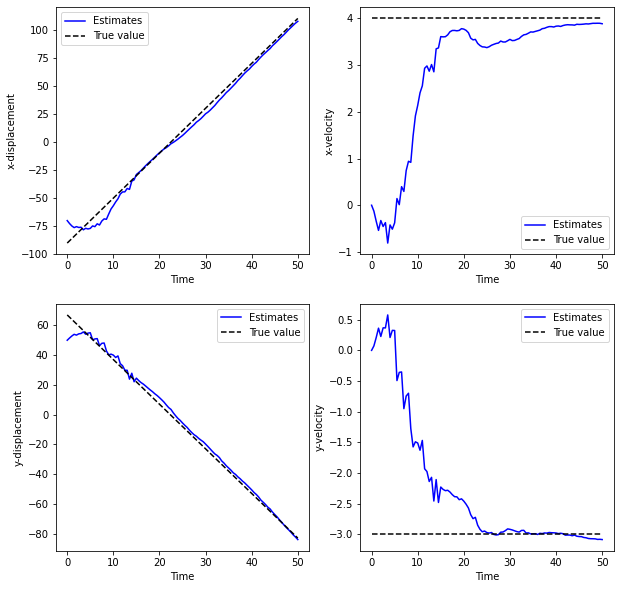

In [78]:
xt = np.arange(N+1)*Dt
xxt = (np.arange(N)+1)*Dt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

ax1.plot(xt, Estim[0],'b',label='Estimates')
ax1.plot(xt, InitVal[0]*np.ones(N+1) + xt*InitVal[2],'k--',label='True value')
ax1.set_xlabel('Time')
ax1.set_ylabel('x-displacement')
ax1.legend()

ax2.plot(xt, Estim[2],'b',label='Estimates')
ax2.plot(xt, TrueVal[2]*np.ones(N+1),'k--',label='True value')
ax2.set_xlabel('Time')
ax2.set_ylabel('x-velocity')
ax2.legend()

ax3.plot(xt, Estim[1],'b',label='Estimates')
ax3.plot(xt, InitVal[1]*np.ones(N+1) + xt*InitVal[3],'k--',label='True value')
ax3.set_xlabel('Time')
ax3.set_ylabel('y-displacement')
ax3.legend()

ax4.plot(xt, Estim[3],'b',label='Estimates')
ax4.plot(xt, TrueVal[3]*np.ones(N+1),'k--',label='True value')
ax4.set_xlabel('Time')
ax4.set_ylabel('y-velocity')
ax4.legend()

Text(0, 0.5, '$\\sigma^2_{x} + \\sigma^2_{y}$')

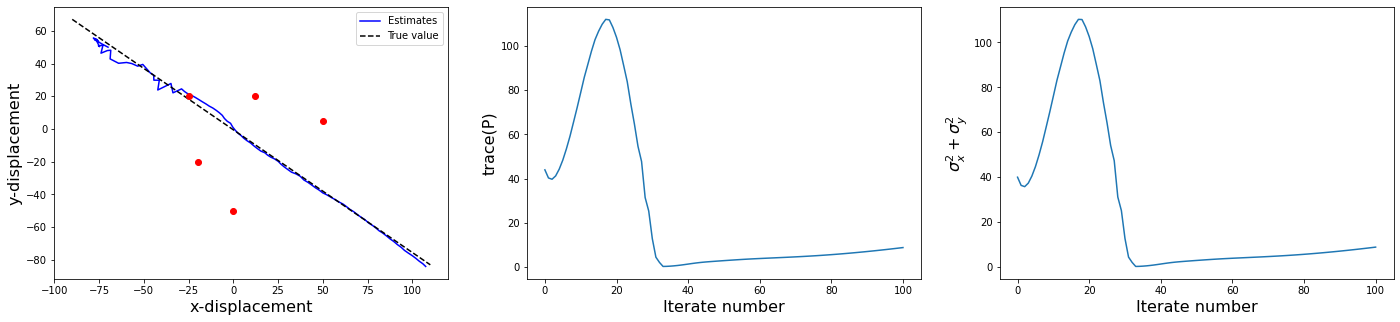

In [79]:
xt = np.arange(N+1)*Dt

fig, (ax1 , ax2, ax3) = plt.subplots(1, 3, figsize=(24, 5))

ax1.plot(Estim[0], Estim[1],'b',label='Estimates')
ax1.plot(InitVal[0]*np.ones(N+1) + xt*InitVal[2], InitVal[1]*np.ones(N+1) + xt*InitVal[3],'k--',label='True value')
ax1.plot(S[0],S[1],'ro')
ax1.set_xlabel('x-displacement', fontsize=16)
ax1.set_ylabel('y-displacement', fontsize=16)
ax1.legend()

ax2.plot(np.arange(N+1), Trace.T)
ax2.set_xlabel('Iterate number', fontsize=16)
ax2.set_ylabel('trace(P)', fontsize=16)

ax3.plot(np.arange(N+1), Sigma.T)
ax3.set_xlabel('Iterate number', fontsize=16)
ax3.set_ylabel('$\sigma^2_{x} + \sigma^2_{y}$', fontsize=16)